### Import section

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

### Helper functions

In [15]:
def convert_categorical_values_to_numerical(df: pd.DataFrame, columns: []):
    for col in columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes
    return df


def split_train_validation_set(df: pd.DataFrame, validation_percent=0.1):
    size = df.shape[0]
    mask = np.random.rand(size) > validation_percent
    train = df[mask]
    test = df[~mask]
    return train, test

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print("Accuracy: ", acc)
    print("F1 score: ", f1)
    print("Confusion matrix: \n", conf_matrix)

def plot_history(history):
    # plot accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Categorical accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Loading and splitting data

In [3]:
FILE_NAME = './nursery.data'
data = pd.read_csv(FILE_NAME, header=None)
print("Classes in dataset and their distributions:")
print(np.unique(data.values[:, 8], return_counts=True))
# Removing 2 examples of class recommend
data = data[data.values[:, 8] != 'recommend']
NUM_OF_CLASSES = len(np.unique(data.values[:, 8]))
cols = data.columns
data = convert_categorical_values_to_numerical(data, cols)
train, test = split_train_validation_set(data)
print("\nAfter removal and conversion to categorical values")
print("\nTrain set:")
print(np.unique(train.values[:, 8], return_counts=True))
print("\nTest set:")
print(np.unique(test.values[:, 8], return_counts=True))

Classes in dataset and their distributions:
(array(['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom'],
      dtype=object), array([4320, 4266,    2, 4044,  328], dtype=int64))

After removal and conversion to categorical values

Train set:
(array([0, 1, 2, 3], dtype=int8), array([3881, 3835, 3647,  302], dtype=int64))

Test set:
(array([0, 1, 2, 3], dtype=int8), array([439, 431, 397,  26], dtype=int64))


### Loss functions

In [4]:
def loss_func(y_true: tf.Tensor, y_pred: tf.Tensor):
    # loss = -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(1e-15 + y_pred), axis=1), axis=0)
    loss = -tf.reduce_sum(y_true * tf.math.log(1e-15 + y_pred), axis=1)
    return loss

def rmse(predictions, targets):
    differences = predictions - targets
    differences_squared = differences ** 2
    mean_of_differences_squared = tf.math.reduce_mean(differences_squared)
    rmse_val = tf.math.sqrt(mean_of_differences_squared)
    return rmse_val

### Model

In [5]:
def create_model(input_shape: int, num_of_classes, dense_neurons=128):
    input = keras.layers.Input(shape=(input_shape))
    layer1 = keras.layers.Dense(dense_neurons, activation=keras.activations.relu, name='dense1')(input)
    layer2 = keras.layers.Dense(dense_neurons, activation=keras.activations.relu, name='dense2')(layer1)
    layer3 = keras.layers.Dense(num_of_classes, activation=keras.activations.softmax, name='dense3')(layer2)

    model = keras.models.Model(inputs=input, outputs=layer3)

    opt = keras.optimizers.Adam(0.001)
    # model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    model.compile(optimizer=opt, loss=loss_func, metrics=['categorical_accuracy'])
    model.summary()
    return model

### Data normalization

In [6]:
X = train.values[:, 0:8]
Y = train.values[:, 8]
scaler = StandardScaler()
X = scaler.fit_transform(X)


### Correlation

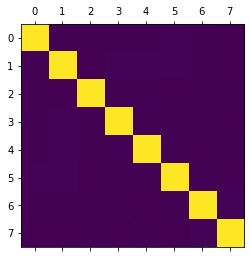

0         1         2         3         4         5         6  \
0  1.000000  0.000377 -0.000177 -0.000282  0.000398  0.004612 -0.000521   
1  0.000377  1.000000 -0.001959  0.003311  0.006059  0.003886  0.001640   
2 -0.000177 -0.001959  1.000000  0.001594 -0.000960 -0.005533  0.001560   
3 -0.000282  0.003311  0.001594  1.000000  0.000095 -0.001267  0.001456   
4  0.000398  0.006059 -0.000960  0.000095  1.000000  0.000855 -0.002678   
5  0.004612  0.003886 -0.005533 -0.001267  0.000855  1.000000 -0.000954   
6 -0.000521  0.001640  0.001560  0.001456 -0.002678 -0.000954  1.000000   
7 -0.002555 -0.002753  0.000959 -0.003330 -0.001564 -0.002395  0.002966   

          7  
0 -0.002555  
1 -0.002753  
2  0.000959  
3 -0.003330  
4 -0.001564  
5 -0.002395  
6  0.002966  
7  1.000000  


In [7]:
correlation_matrix = pd.DataFrame(X).corr()

plt.matshow(correlation_matrix)
plt.show()
print(correlation_matrix)

### PCA

In [8]:
pca = PCA(random_state=1)
pca.fit(data.values[:, 0:8])


PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

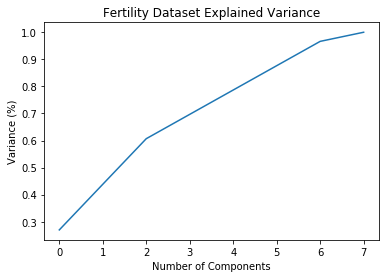

In [9]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Fertility Dataset Explained Variance')
plt.show()

In [102]:
pca = PCA(random_state=1, n_components=7)
X = pca.fit_transform(X)

### Creating model and training model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1152      
_________________________________________________________________
dense2 (Dense)               (None, 128)               16512     
_________________________________________________________________
dense3 (Dense)               (None, 4)                 516       
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
_________________________________________________________________
Train on 10498 samples, validate on 1167 samples
Epoch 1/100
10498/10498 - 1s - loss: 0.4354 - categorical_accuracy: 0.8436 - val_loss: 0.1742 - val_categorical_accuracy: 0.9323
Epoch 2/100
10498/10498 - 1s - loss: 0.2045 - categorical_accuracy: 0.9152 

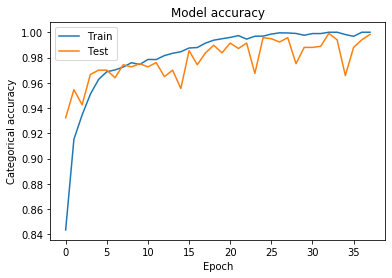

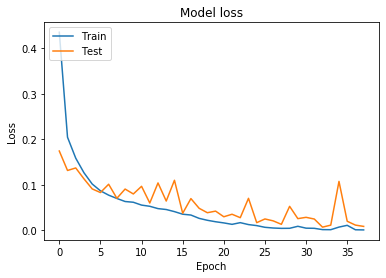

In [16]:
model = create_model(input_shape=X.shape[1], num_of_classes=NUM_OF_CLASSES)

es = EarlyStopping(monitor='val_loss', mode='auto', patience=5, verbose=1)
callbacks = [es]

hist = model.fit(x=X, y=keras.utils.to_categorical(Y),
    callbacks=callbacks,
    epochs=100,
    verbose=2, 
    validation_split=0.1)
model.save('model.h5')
plot_history(hist)

### Model testing

In [117]:
X_test = test.values[:, 0:8]
X_test = scaler.transform(X_test)
Y_test = test.values[:, 8]
predictions = model.predict(X_test)
Y_pred = predictions.argmax(axis=1)

In [52]:
# num of neurons 64, 3 layers, early stopping
evaluate_model(Y_test, Y_pred)

Accuracy:  0.98828125
F1 score:  0.980644313215117
Confusion matrix: 
 [[417   0   0   0]
 [  0 398  10   1]
 [  0   2 418   0]
 [  0   2   0  32]]


In [69]:
# num of neurons 128, 3 layers, early stopping, improved performance on training set
evaluate_model(Y_test, Y_pred)

Accuracy:  0.99765625
F1 score:  0.9981902118623717
Confusion matrix: 
 [[417   0   0   0]
 [  0 407   2   0]
 [  0   1 419   0]
 [  0   0   0  34]]


In [73]:
# num of neurons 64, 4 layers, early stopping
evaluate_model(Y_test, Y_pred)

Accuracy:  0.97109375
F1 score:  0.9673991378691722
Confusion matrix: 
 [[417   0   0   0]
 [  0 393  15   1]
 [  0  19 401   0]
 [  0   2   0  32]]


In [78]:
# num of neurons 128, 2 layers, early stopping
evaluate_model(Y_test, Y_pred)

Accuracy:  0.97578125
F1 score:  0.9556440995280548
Confusion matrix: 
 [[417   0   0   0]
 [  0 393  15   1]
 [  0   9 411   0]
 [  0   6   0  28]]


In [86]:
# optimizer SGD,  num of neurons 128, 3 layers,
evaluate_model(Y_test, Y_pred)

Accuracy:  0.97421875
F1 score:  0.9502422282057217
Confusion matrix: 
 [[417   0   0   0]
 [  0 389  19   1]
 [  0   6 414   0]
 [  0   7   0  27]]


In [90]:
# optimizer Nadam,  num of neurons 128, 3 layers,
evaluate_model(Y_test, Y_pred)

Accuracy:  0.9890625
F1 score:  0.9915484055134165
Confusion matrix: 
 [[417   0   0   0]
 [  0 395  14   0]
 [  0   0 420   0]
 [  0   0   0  34]]


In [109]:
# PCA
X_test = test.values[:, 0:8]
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
Y_test = test.values[:, 8]
predictions = model.predict(X_test)
Y_pred = predictions.argmax(axis=1)
evaluate_model(Y_test, Y_pred)

Accuracy:  0.953125
F1 score:  0.9004453917694863
Confusion matrix: 
 [[413   1   3   0]
 [  0 391  17   1]
 [  1  23 396   0]
 [  0  13   1  20]]


In [114]:
# L2 regularization
evaluate_model(Y_test, Y_pred)

Accuracy:  0.928125
F1 score:  0.7055222954503529
Confusion matrix: 
 [[417   0   0   0]
 [  0 371  38   0]
 [  0  20 400   0]
 [  0  34   0   0]]


### Final result

In [118]:
evaluate_model(Y_test, Y_pred)

Accuracy:  0.99296875
F1 score:  0.9945709832479797
Confusion matrix: 
 [[417   0   0   0]
 [  0 405   4   0]
 [  0   5 415   0]
 [  0   0   0  34]]
